In [1]:
import matplotlib.pyplot as plt
import numpy as np

import PyFWI.wave_propagation as wave
import PyFWI.acquisition as acq
import PyFWI.seiplot as splt
import PyFWI.model_dataset as md
import PyFWI.fwi_tools as tools
import PyFWI.processing as process
from PyFWI.fwi import FWI

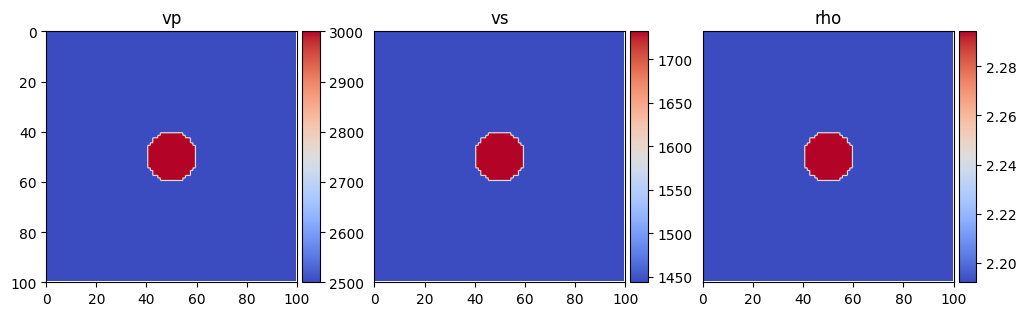

In [2]:
Model = md.ModelGenerator('louboutin')
model = Model()

im = splt.earth_model(model, cmap='coolwarm')

In [3]:
model_shape = model[[*model][0]].shape

inpa = {
    'ns': 4,  # Number of sources
    'sdo': 4,  # Order of FD
    'fdom': 15,  # Central frequency of source
    'dh': 7,  # Spatial sampling rate
    'dt': 0.004,  # Temporal sampling rate
    'acq_type': 0,  # Type of acquisition (0: crosswell, 1: surface, 2: both)
    't': 0.6,  # Length of operation
    'npml': 20,  # Number of PML
    'pmlR': 1e-5,  # Coefficient for PML (No need to change)
    'pml_dir': 2,  # type of boundary layer
}

seisout = 0 # Type of output 0: Pressure

inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance

In [4]:
offsetx = inpa['dh'] * model_shape[1]
depth = inpa['dh'] * model_shape[0]

src_loc, rec_loc, n_surface_rec, n_well_rec = acq.acq_parameters(inpa['ns'],
                                                                 inpa['rec_dis'],
                                                                 offsetx,
                                                                 depth,
                                                                 inpa['dh'],
                                                                 inpa['sdo'],
                                                                 acq_type=inpa['acq_type'])
# src_loc[:, 1] -= 5 * inpa['dh']

# Create the source
src = acq.Source(src_loc, inpa['dh'], inpa['dt'])
src.Ricker(inpa['fdom'])

In [5]:
# Create the wave object
W = wave.WavePropagator(inpa, src, rec_loc, model_shape,
                        n_well_rec=n_well_rec,
                        components=seisout, chpr=0)

# Call the forward modelling
d_obs = W.forward_modeling(model, show=False)  # show=True can show the propagation of the wave

C:\Users\DIP KR SINGHA\anaconda3\envs\pyfwi_env\lib\site-packages\pyopencl\cache.py:420: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, [devices[i] for i in to_be_built_indices])


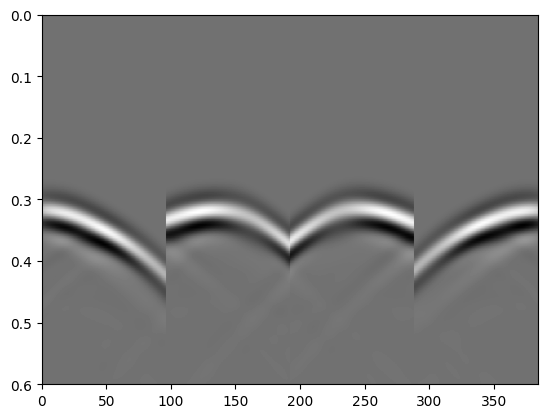

In [6]:
plt.imshow(d_obs["taux"], cmap='gray',
           aspect="auto", extent=[0, d_obs["taux"].shape[1], inpa['t'], 0])

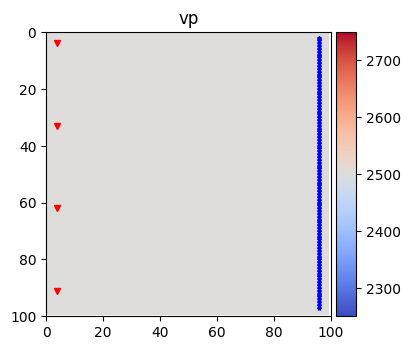

In [7]:
m0 = Model(smoothing=1)
m0['vs'] *= 0.0
m0['rho'] = np.ones_like(model['rho'])

fig = splt.earth_model(m0, ['vp'], cmap='coolwarm')

fig.axes[0].plot(src_loc[:,0]//inpa["dh"],
                 src_loc[:,1]//inpa["dh"], "rv", markersize=5)

fig.axes[0].plot(rec_loc[:,0]//inpa["dh"],
                 rec_loc[:,1]//inpa["dh"], "b*", markersize=3)

In [8]:
fwi = FWI(d_obs, inpa, src, rec_loc, model_shape,
          components=seisout, chpr=20, n_well_rec=n_well_rec)

C:\Users\DIP KR SINGHA\anaconda3\envs\pyfwi_env\lib\site-packages\pyopencl\cache.py:496: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


In [9]:
n_params = 1
k_0 = 1
k_end = 2

In [10]:
m_est, _ = fwi(m0, method="lbfgs",
                 freqs=[25, 45], iter=[2, 2],
                 n_params=1, k_0=1, k_end=2)

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 0.000318761303788051 with rms_reg: 0, and rms_data: 0.000318761303788051, rms_mp: 0.0, rms_model_relation: 0
Parameter number 1 to 1
2500.0 2500.0
 for f= 45: rms is: 0.004415073897689581 with rms_reg: 0, and rms_data: 0.004415073897689581, rms_mp: 0.0, rms_model_relation: 0
2499.9817678056447 2500.0327078320643
 for f= 45: rms is: 0.004414360038936138 with rms_reg: 0, and rms_data: 0.004414360038936138, rms_mp: 0.0, rms_model_relation: 0
2499.908839028223 2500.1635391603213
 for f= 45: rms is: 0.004411503206938505 with rms_reg: 0, and rms_data: 0.004411503206938505, rms_mp: 0.0, rms_model_relation: 0
2499.617123918538 2500.68686447335
 for f= 45: rms is: 0.004400104284286499 with rms_reg: 0, and rms_data: 0.004400104284286499, rms_mp: 0.0, rms_model_relation: 0
2498.450263479796 2502.7801657254645
 for f= 45: rms is: 0.004354971926659346 with rms_reg: 0, and rms_data: 0.004354971926659346, rms_mp: 0.0, rms_model_relation: 0
249

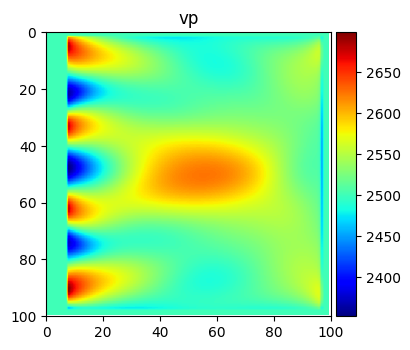

In [11]:
# Time to plot the results
fig = splt.earth_model(m_est, ['vp'], cmap='jet')